Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNNAssignment1-images/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNNAssignment1-images/Test')
data_dir=pathlib.Path('/content/drive/MyDrive/CNNAssignment1-images')


In [4]:
def scanfile (all_data_dir = data_dir, training_data_dir = data_dir_train, testing_data_dir=data_dir_test):

    print("Folders and Files in Trian directory")
    for subdir, dirs, files in os.walk(training_data_dir):

        trian_category_name = os.path.basename(subdir)
        if trian_category_name == os.path.basename(training_data_dir):
              continue
        print(str(trian_category_name) + ' has ' + str(len(files)) + ' images')

    print("\nFolders and Files in Test directory")
    for subdir, dirs, files in os.walk(testing_data_dir):

        test_category_name = os.path.basename(subdir)

        if test_category_name == os.path.basename(testing_data_dir):
              continue
        print(str(test_category_name) + ' has ' + str(len(files)) + ' images')

In [5]:
scanfile()

Folders and Files in Trian directory
nevus has 357 images
squamous cell carcinoma has 181 images
seborrheic keratosis has 77 images
vascular lesion has 139 images
basal cell carcinoma has 376 images
actinic keratosis has 114 images
melanoma has 438 images
pigmented benign keratosis has 462 images
dermatofibroma has 95 images

Folders and Files in Test directory
vascular lesion has 3 images
squamous cell carcinoma has 16 images
seborrheic keratosis has 3 images
pigmented benign keratosis has 16 images
basal cell carcinoma has 16 images
nevus has 16 images
actinic keratosis has 16 images
dermatofibroma has 16 images
melanoma has 16 images


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

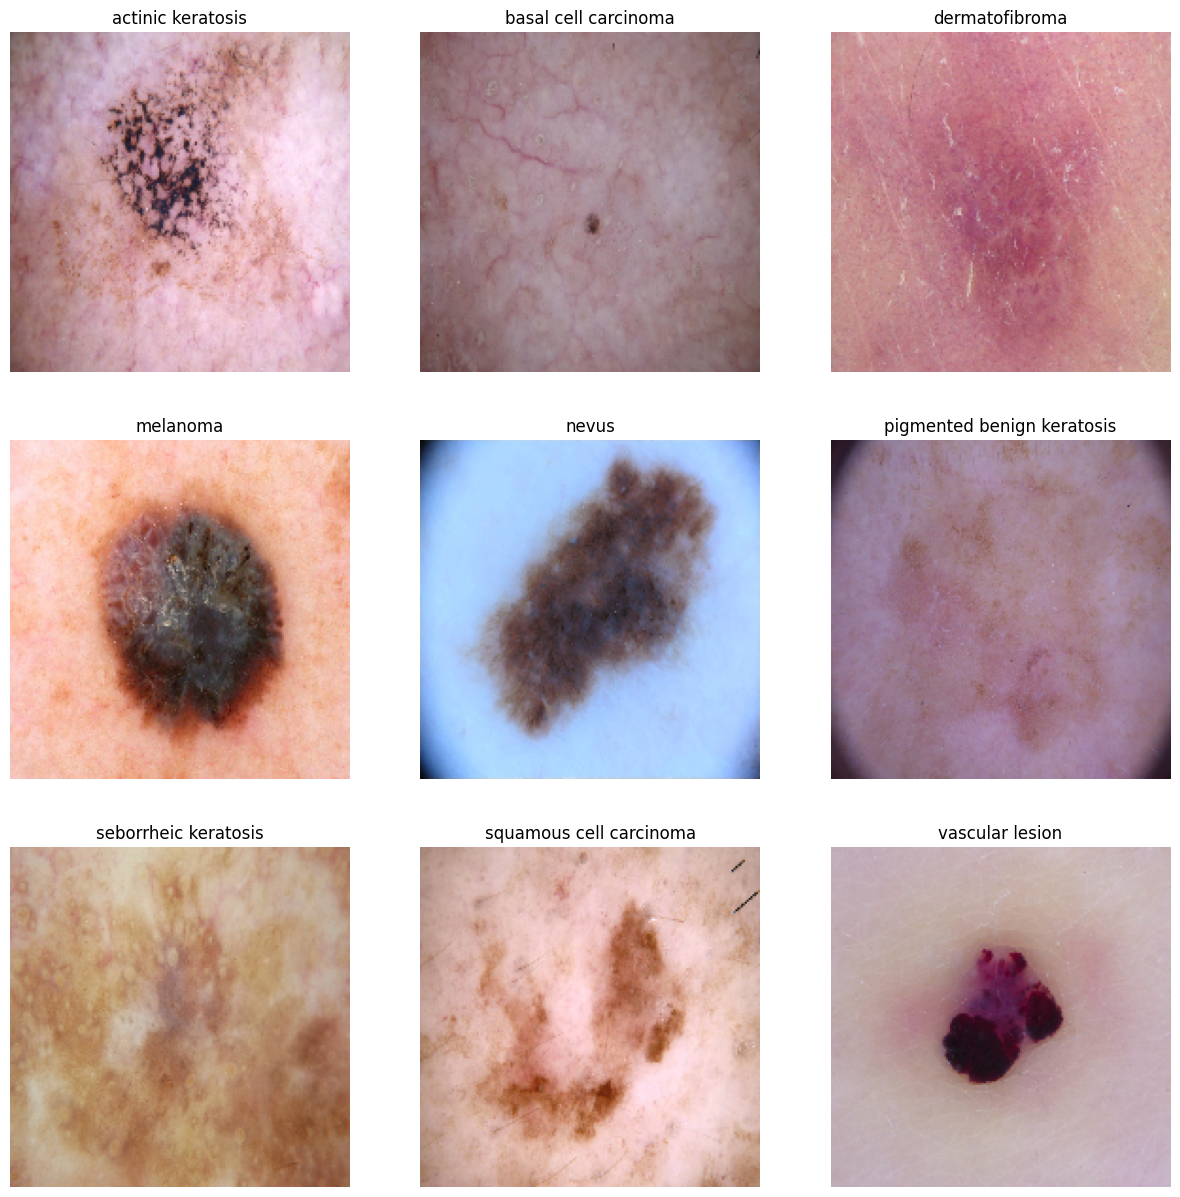

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

### your code goes here, you can use training or validation data to visualize
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 41, 41, 128)      

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 60ms/step - loss: 2.1361 - accuracy: 0.1869 - val_loss: 2.0505 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 1.9062 - accuracy: 0.3008 - val_loss: 1.6567 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 1.6456 - accuracy: 0.4180 - val_loss: 1.5252 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.4835 - accuracy: 0.4905 - val_loss: 1.5435 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4431 - accuracy: 0.5033 - val_loss: 1.3879 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3712 - accuracy: 0.5285 - val_loss: 1.3310 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 3s 53ms/step - loss: 1.3180 - accuracy: 0.5424 - val_loss: 1.5082 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing training results

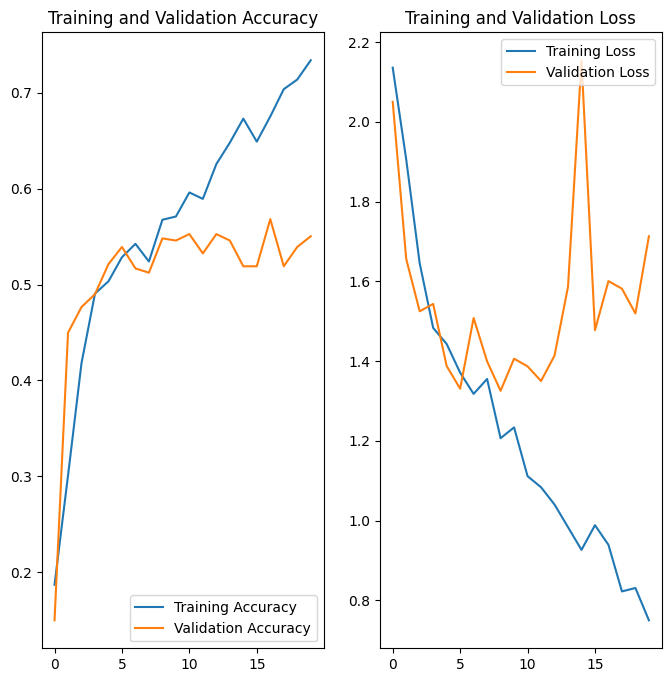

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

*Finding on the first base model**

- The model is overfitting because we can also see difference in loss functions in training & validation

- The accuracy is just around 70-75% because there are enough features to remember the pattern.


### Write your findings here

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
from tensorflow.keras import layers
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

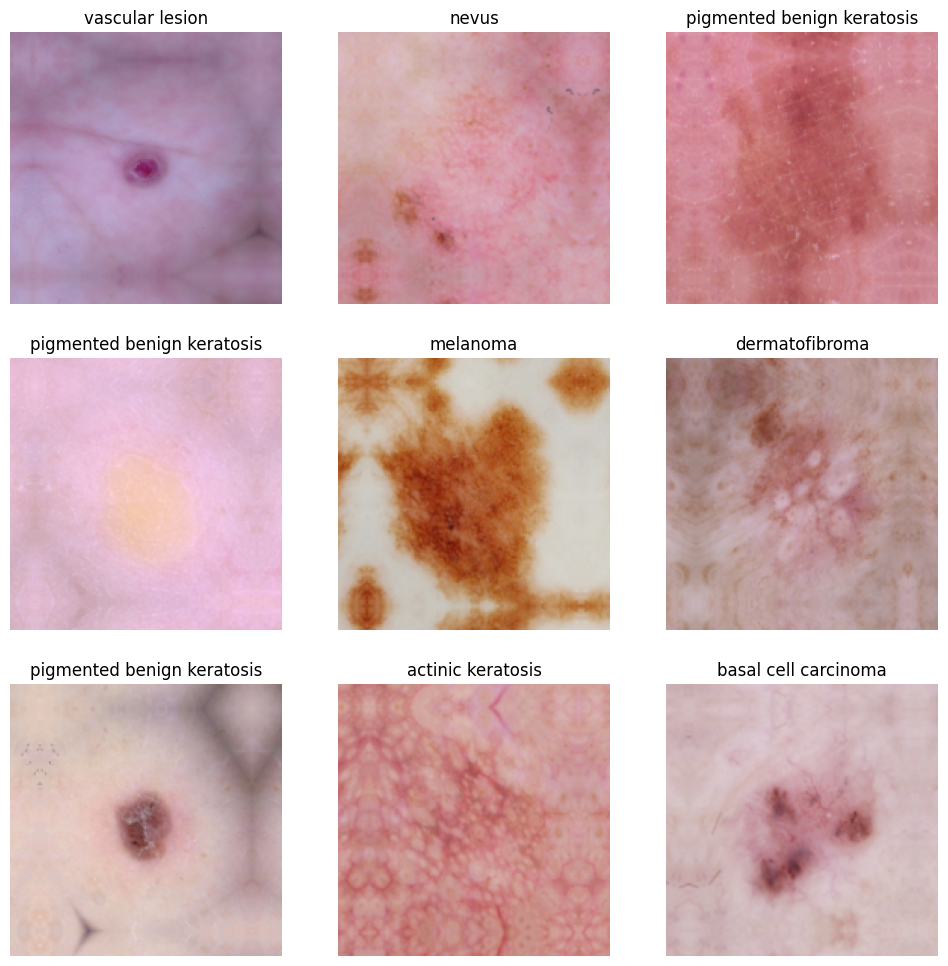

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from tensorflow.keras.layers import BatchNormalization


model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 89, 89, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 43, 43, 64)       

### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 62ms/step - loss: 4.8787 - accuracy: 0.3142 - val_loss: 2.5856 - val_accuracy: 0.0559
Epoch 2/20
56/56 [==============================] - 3s 61ms/step - loss: 2.4979 - accuracy: 0.3856 - val_loss: 2.1996 - val_accuracy: 0.1611
Epoch 3/20
56/56 [==============================] - 3s 59ms/step - loss: 1.8675 - accuracy: 0.4314 - val_loss: 2.7956 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 3s 57ms/step - loss: 1.5937 - accuracy: 0.4833 - val_loss: 3.5563 - val_accuracy: 0.1655
Epoch 5/20
56/56 [==============================] - 3s 61ms/step - loss: 1.4580 - accuracy: 0.4905 - val_loss: 2.7583 - val_accuracy: 0.1790
Epoch 6/20
56/56 [==============================] - 3s 60ms/step - loss: 1.2579 - accuracy: 0.5564 - val_loss: 2.7733 - val_accuracy: 0.2103
Epoch 7/20
56/56 [==============================] - 3s 57ms/step - loss: 1.1736 - accuracy: 0.5854 - val_loss: 3.1560 - val_accuracy: 0.2349
Epoch 8/20
56

### Visualizing the results

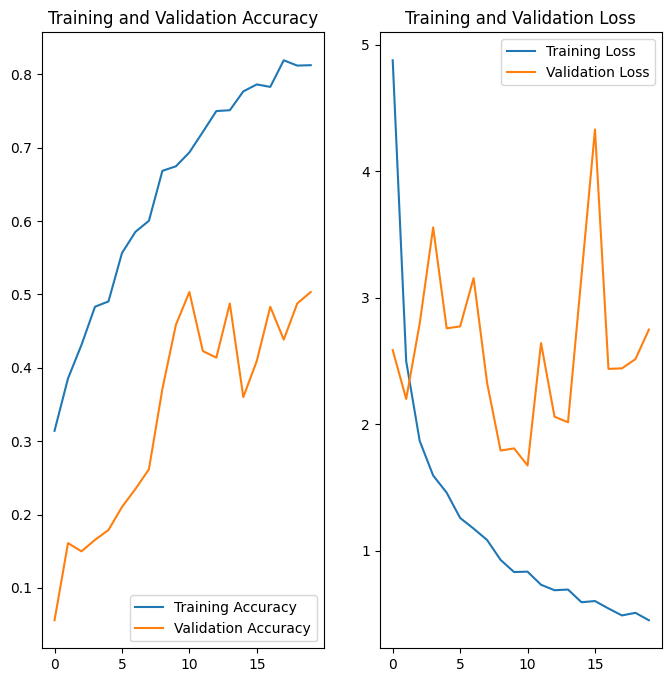

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- little bit of accuracy improvement in trianing but overfitting issue still present.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [38]:
## Your code goes here.
##
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
1,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
2,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
3,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
4,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion
2235,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion
2236,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion
2237,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion


In [39]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
1,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
2,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
3,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
4,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion
2235,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion
2236,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion
2237,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion


<BarContainer object of 9 artists>

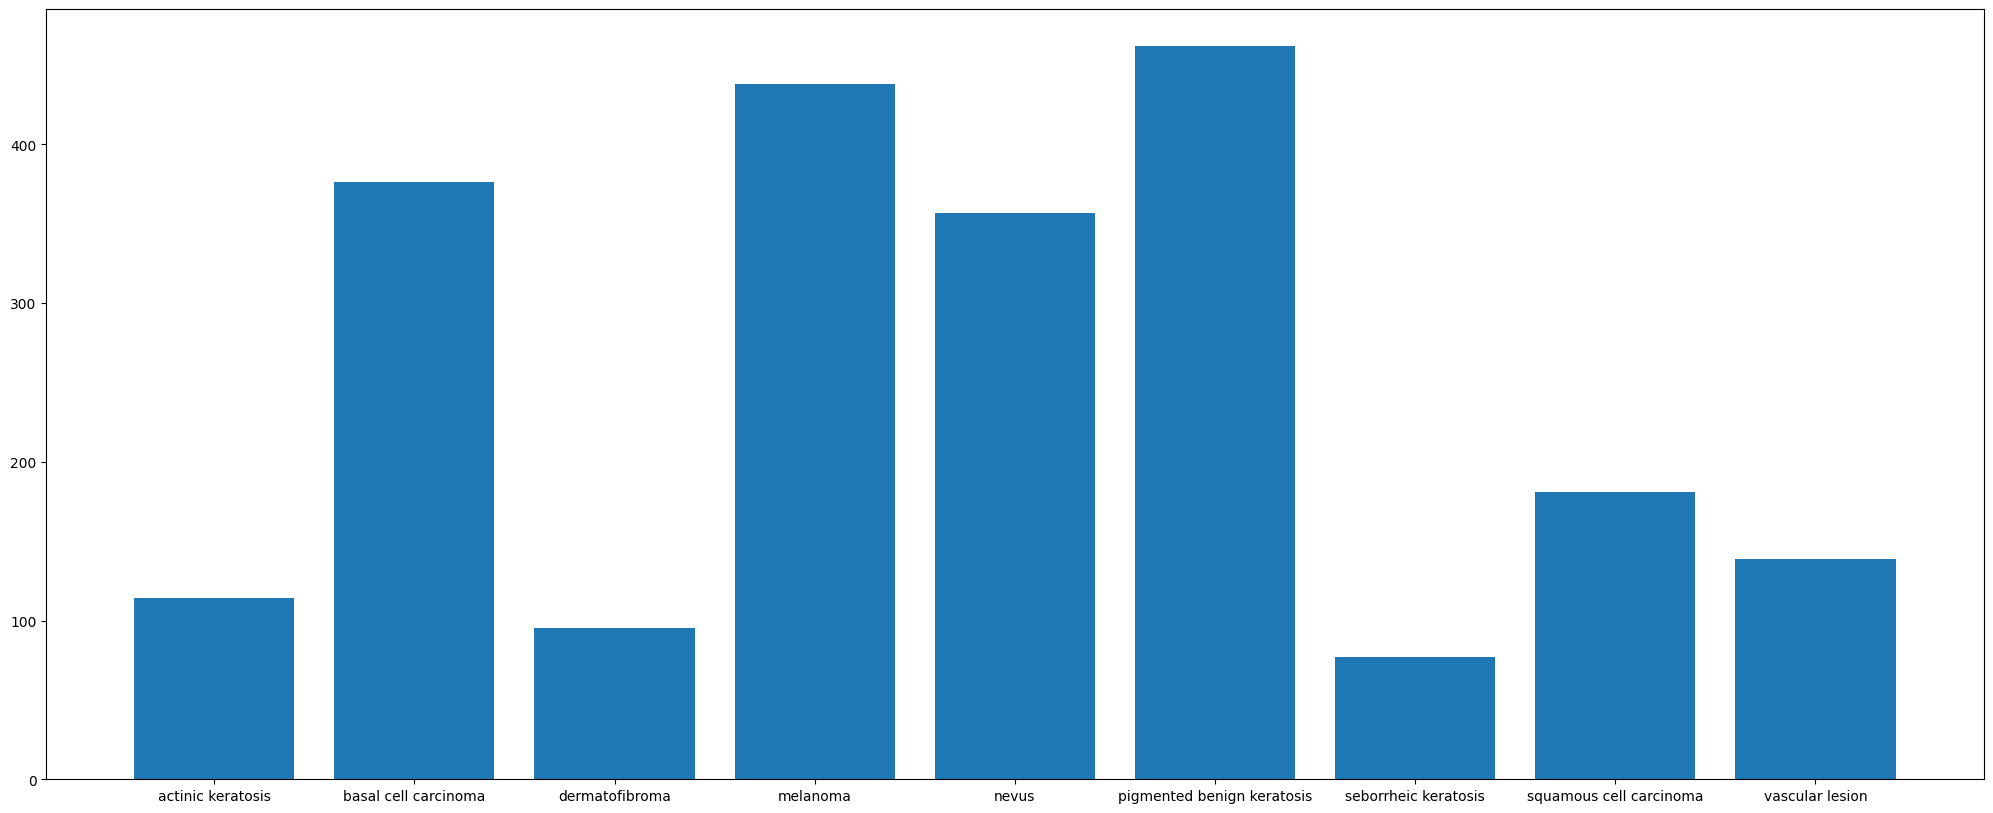

In [40]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
basal cell carcinoma, melanoma, pigmented benign keratosis,nevus


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
path_to_training_dataset="/content/drive/MyDrive/CNNAssignment1-images/Train"

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline("/content/drive/MyDrive/CNNAssignment1-images/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment1-images/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7940841E38B0>: 100%|██████████| 500/500 [00:40<00:00, 12.38 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment1-images/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7940E06013F0>: 100%|██████████| 500/500 [00:46<00:00, 10.76 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment1-images/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7940E07134C0>: 100%|██████████| 500/500 [00:41<00:00, 12.04 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment1-images/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7940792AC640>: 100%|██████████| 500/500 [00:45<00:00, 11.01 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment1-images/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7940E03EF400>: 100%|██████████| 500/500 [00:43<00:00, 11.52 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment1-images/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7940795AC8B0>: 100%|██████████| 500/500 [00:35<00:00, 13.94 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment1-images/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7940F844E890>: 100%|██████████| 500/500 [00:40<00:00, 12.49 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment1-images/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7940F84B6F50>: 100%|██████████| 500/500 [00:46<00:00, 10.75 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment1-images/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7940794A2920>: 100%|██████████| 500/500 [00:43<00:00, 11.56 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [42]:
data_dir_train_augmented=pathlib.Path("/content/drive/MyDrive/CNNAssignment1-images/Train/output")
image_count_train = len(list(data_dir_train_augmented.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
##
for i in class_names:

    for j in data_dir_train_augmented.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
1,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
2,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
3,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
4,/content/drive/MyDrive/CNNAssignment1-images/T...,actinic keratosis
...,...,...
6734,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion
6735,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion
6736,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion
6737,/content/drive/MyDrive/CNNAssignment1-images/T...,vascular lesion


In [45]:
new_df['Label'].value_counts()

pigmented benign keratosis    1366
melanoma                      1306
basal cell carcinoma          1145
nevus                         1084
squamous cell carcinoma        560
vascular lesion                395
actinic keratosis              359
dermatofibroma                 308
seborrheic keratosis           216
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [46]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [48]:
data_dir_train_aug="/content/drive/MyDrive/CNNAssignment1-images/Train/output"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [2]:
## your code goes here
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()


NameError: name 'Sequential' is not defined

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [1]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

NameError: name 'model' is not defined

#### **Todo:**  Visualize the model results

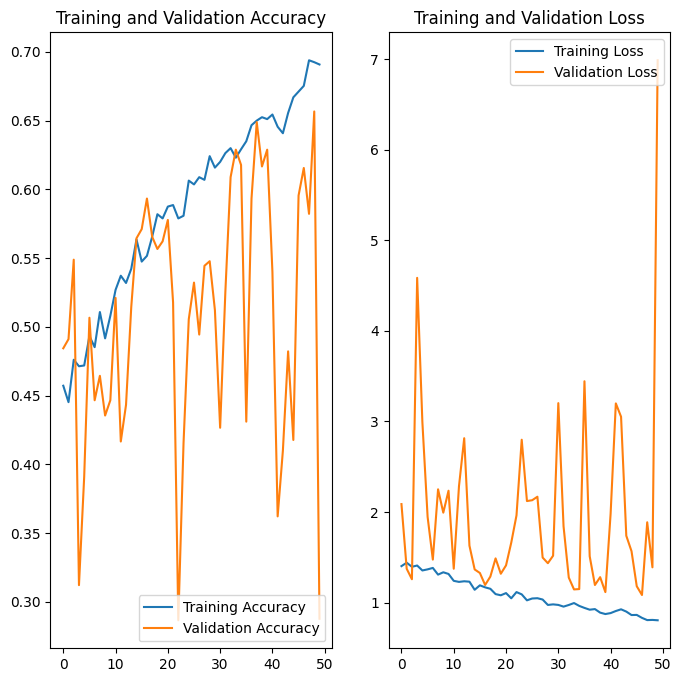

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 41, 41, 128)      

In [ ]:
###Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])



In [ ]:
# Train the model

epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 9) are incompatible


In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()
